In [39]:
!pip install scikit-learn pandas numpy matplotlib seaborn joblib

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

import joblib
import seaborn as sns

In [48]:
df = pd.read_csv("transactions.csv")
print("Shape:", df.shape)
df.head()

Shape: (5000, 8)


,date,amount,description,category,type,payment_method,installments,monthly_payment
0,2024-01-22,1.00,University tuition payment,Education,expense,cash,0,0.00
1,2023-04-04,1.00,Gas bill,Utilities,expense,debit_card,0,0.00
2,2023-11-19,4.95,Aldi grocery,Food,expense,credit_card,1,4.95
3,2023-08-17,86.88,University tuition payment,Education,expense,debit_card,0,0.00
4,2024-09-23,35.26,Subway sandwich,Food,expense,debit_card,0,0.00


In [49]:
df["date"] = pd.to_datetime(df["date"])

df["month"] = df["date"].dt.month

# pandas weekday: Monday=0 → Sunday=6
df["day_of_week"] = df["date"].dt.dayofweek + 1  # NOW Monday=1 ... Sunday=7
df["is_weekend"] = df["day_of_week"].isin([6,7]).astype(int)


In [50]:
X = df[[
    "description",
    "amount",
    "month",
    "day_of_week",
    "is_weekend",
    "installments",
    "monthly_payment",
    "payment_method"
]]

y = df["category"]

In [51]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape

((4000, 8), (1000, 8))

In [52]:
text_feature = "description"

numeric_features = [
    "amount",
    "month",
    "day_of_week",
    "is_weekend",
    "installments",
    "monthly_payment"
]

categorical_features = ["payment_method"]

preprocessor = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(
            max_features=5000,
            ngram_range=(1,2)
        ), text_feature),

        ("numeric", StandardScaler(), numeric_features),

        ("categorical", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

In [53]:
clf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", clf)
    ]
)

In [54]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=5000,
                                                                  ngram_range=(1,
                                                                               2)),
                                                  'description'),
                                                 ('numeric', StandardScaler(),
                                                  ['amount', 'month',
                                                   'day_of_week', 'is_weekend',
                                                   'installments',
                                                   'monthly_payment']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['payment_method'])])),
                ('classifier',
                 RandomForestClassifier(n_estimators=300, n_jobs=-1,
                                        random_state=42))])

In [56]:
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", round(acc, 4))
print(classification_report(y_test, y_pred))

Test Accuracy: 1.0
                precision    recall  f1-score   support

     Education       1.00      1.00      1.00        50
 Entertainment       1.00      1.00      1.00       100
          Food       1.00      1.00      1.00       253
        Health       1.00      1.00      1.00        69
        Income       1.00      1.00      1.00       128
      Shopping       1.00      1.00      1.00       153
Transportation       1.00      1.00      1.00       155
     Utilities       1.00      1.00      1.00        92

      accuracy                           1.00      1000
     macro avg       1.00      1.00      1.00      1000
  weighted avg       1.00      1.00      1.00      1000



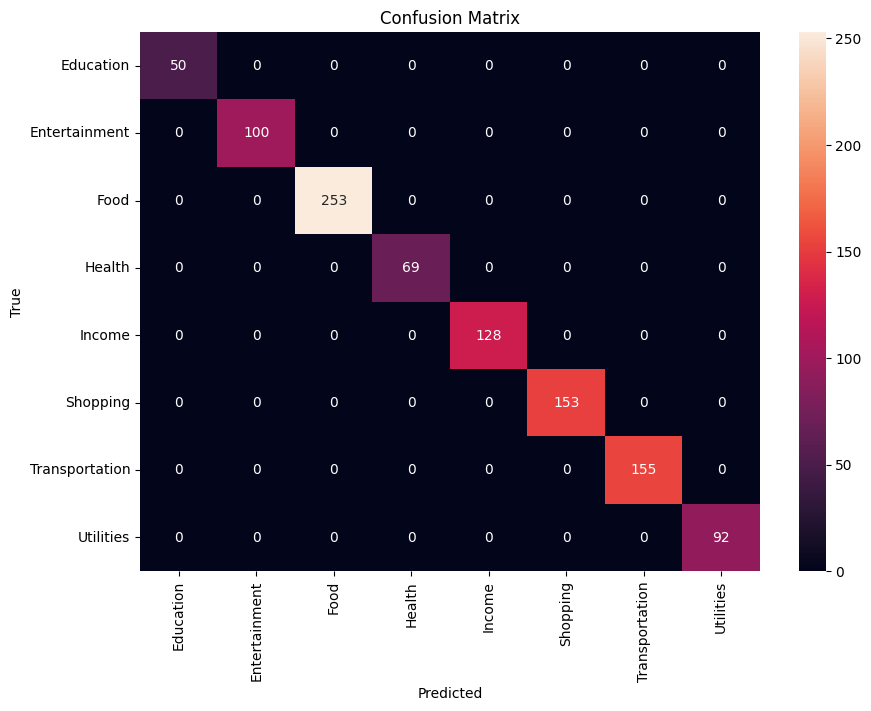

In [57]:
cm = confusion_matrix(y_test, y_pred, labels=sorted(df["category"].unique()))

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=sorted(df["category"].unique()),
            yticklabels=sorted(df["category"].unique()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [58]:
scores = cross_val_score(
    model, X, y,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

print("CV Scores:", scores)
print("Mean CV Accuracy:", scores.mean())

CV Scores: [1.    0.995 0.998 1.    1.   ]
Mean CV Accuracy: 0.9986


In [59]:
joblib.dump(model, "category_classifier.pkl")
print("Model saved as category_classifier.pkl")

Model saved as category_classifier.pkl
